# Calibration

The initial demonstration of calibration in CNGI/ngCASA is centered around a streamlined implementation of on-the-fly self-calibration for synthesis visibility data. The purpose of the prototype implementation of self_cal is to demonstrate the use and throughput of the dask-based parallelization framework in the calibration context, and begin to explore how some essential components of general synthesis calibration (gain solving, application) might appear in python, and built upon the xarray visibility data structures. As such, this prototype is limited in several ways compared to the more conventional approach implemented in traditional CASA. In fact, there is no direct single-execution analog of ngCASA self_cal available within CASA, where self-calibration involves a sequence of executions of gaincal and applycal (and includes multiple passes through the data). In contrast, ngCASA self_cal is a single-pass implementation that takes an input data group (visibilities, weights, flags, and model), performs an antenna-based gain solution (at the native time granularity of the data), applies the result to the input data, and returns a calibrated output data group. Most notably, there is not yet a way to examine the solved-for gain solutions themselves. This is mainly a practical consequence of not yet having designed the calibration solution container (caltable), nor the mechanisms for filling and examining it. Rather, the data product (for now), are the corrected visibilities, appropriate for comparison with the input visibilities and for imaging. More comprehensive tools for generating, managing, and examining calibration will be designed and implemented in ngCASA in future.  Nonetheless, it is thought that a single-pass implementation of the sort demonstrated here will have a role in the processing of data from the larger arrays of the future (ngVLA, etc.) since self-calibration is likely the most I/O- and computationally-intensive calibration use case, insofar as it must process the (usually) most-voluminous science target visibilities in any synthesis visibility dataset. It will also be possible to integrate this self-calibration mechanism within the imaging regime, e.g., to implement a form a difference mapping. Thus, this demonstration is well-tuned to the specific question of applicability of the CNGI/ngCASA framework to the calibration domain.

Note that the self_cal function has not undergone the degree of performance optimization that imaging/gridding has, and is therefore not intended as a demonstration of framework performance.

The ngCASA self_cal function ingests an appropriately time-chunked xarray dataset including (possibly nominally calibrated) visibility data, weights, flags, and model. For each dask chunk in the xarray data group, the input visibility data, model, and weights are conditioned for the solve by (a) zeroing the weights for flagged or absent data, (b) slicing out just the parallel-hands, (c) forming the ratio of visibility and model (including weight update), (d) weighted averaging over frequency channels, (e) (optionally) combining the parallel-hand correlations for a single-pol ('T') solution (including weight update), (f) (optionally) weighted averaging of the time axis up to the virtual dask chunking (including weight update), (g) (optionally) dividing by the visibility amplitudes for phase-only solutions (including weight update). This results in data and weight arrays properly prepared and maximally collapsed for sliced ingestion within the solve loop. Then, for each timestamp and polarization, the solve loop will: (a) detect the available antenna-based constraints, zeroing the weights for all baselines involving antennas with insufficient data according to minblperant, (b) calculate a first guess for the gains based on the available baselines to the specified reference antenna, (c) perform the scalar gain solve via scipy.optimize.least_squares, supplying a weighted-residual calculation function that embodies the (scalar, for now) multiplicative algebra of the visibilities and gains, (d) derive solution error information, and (e) store the solved-for gains in a (temporary) array. Upon completion of the solve loop: (a) phase-only gains are enforced to have unit amplitude (if necessary), (b) the user-specified SNR threshold is applied, and (c) the original data arrays (all channels, correlations, times) are corrected. These results for all dask chunks are then aggregated into a new xarray data group.

Current notable limitations:

-   Only per-integration or per-chunk (dask) solution intervals
-   No spw combine for solve (requires higher-level management of xarray datasets).
-   No refantmode support (mostly inconsequential in this context)
-   No amplitude-only solution
-   No robust solving (e.g., L1) support (scipy.optimize.least_squares options in this area not yet exposed)
-   No solution normalization (e.g. to preserve input f.d. scale)
-   No global refant reconcilation (at worst, cross-hand phase uniformity may be compromised for 'G' solving; otherwise this is inconsequential for OTF self-calibration).
-   No solution normalization (e.g. to preserve input f.d. scale)
-   No gain interpolation in the calibration apply (this is inconsequential for per-integration solutions)o No non-trivial solution mapping on apply (e.g., spwmap, etc.)
-   No access to the raw gain solutions (requires design and implementation of a caltable)
-   No prior calibration apply support



## Installation

In this section, we install the prototype software and download the dataset.


In [ ]:
import os

os.system("pip install --extra-index-url https://test.pypi.org/simple/ cngi-prototype==0.0.86")

!gdown -q --id 1esqPjOVVr-fuox78lqL7kxXv3Dt-T7Ox
!unzip selfcal_sim1_1scan.vis.zarr.zip > /dev/null

%matplotlib widget
import xarray as xr
xr.set_options(display_style="html")
print('complete')

complete


## Run self_cal

In this example, we are self-calibrating simulated full-polarization point-source visibility data.  The putative observation (based on a real ALMA dataset) had 47 antennas in one spectral window, with four correlations in the circular basis.  The data are corrupted by a systematic set of scalar multiplicative gain errors that are constant in time, frequency, and polarization.  Gaussian noise at a typical scale (appropriate for the recorded bandwidth and integration time, and an SEFD of \~8400 Jy).  This example is perhaps atypical for self-cal in the sense that the data are not nominally calibrated to any degree, but since we can asumme a point source model, we can expect a good result.   In this case, we are assuming a 3 Jy (total intensity) point source model, which was stored with the imported data.  Since the gain errors affect all correlations in a systematic way, we can expect the calibration derived from the parallel hands to also properly calibrate the cross-hands, and thereby reveal the linear polarization of the point source (which we "suspect" to be 13%...).

In [ ]:
import xarray as xr
from cngi.dio import read_vis, read_image, write_vis
from ngcasa.calibration import self_cal
from cngi.vis import chan_average, time_average, apply_flags
import dask
xr.set_options(display_style="html")


# Import the data, non-trivially chunking it (virtually) in time (only)

#Dims  (time: 300,baseline: 1128, chan: 11, pol: 4)
#Zarr chunks (time: 10, baseline: 1128, chan: 2, pol: 4)
vis_mxds = read_vis("selfcal_sim1_1scan.vis.zarr",chunks={'time':150,'chan':12})

# apply flags (this isn't strictly necessary, since self-cal will handle flags
#    internally)
vis_mxds_flagged = apply_flags(vis_mxds,vis='xds0')

# Select the 0th data group in xds0 for processing
#   (the corrected data will be added to this data group)
sel_parms = {}
sel_parms['xds'] = 'xds0'
sel_parms['data_group_in_id'] = 0
sel_parms['data_group_out_id'] = 0

# Arrange solving parameters
#   gaintype='T' (single pol solution for all correlations)
#   solint='int' (per-integration solutions)
#   refant_id=4  (pick a refant, any refant)
#   (let other parameters default)
solve_parms= {}
solve_parms['gaintype']='T'
solve_parms['solint']='int'
solve_parms['refant_id']=4
# solve_parms['phase_only']=False
# solve_parms['minsnr']=0.0
# solve_parms['minblperant']=4

# Run the self_cal function
sc_vis_mxds = self_cal(vis_mxds_flagged, solve_parms, sel_parms)

# Export the corrected data to a new zarr
write_vis(sc_vis_mxds,"cor_selfcal_sim1_1scan.vis.zarr")
#sc_vis_mxds.xds0

######################### Start self_cal #########################
Setting default phase_only  to  False
Setting default minsnr  to  0.0
Setting default minblperant  to  4
Setting default ginfo  to  False
Setting data_group_in  to  {'data': 'DATA', 'flag': 'FLAG', 'id': '0', 'uvw': 'UVW', 'weight': 'DATA_WEIGHT'}
Setting default data_group_out [' data ']  to  DATA
Setting default data_group_out [' flag ']  to  FLAG
Setting default data_group_out [' uvw ']  to  UVW
Setting default data_group_out [' weight ']  to  DATA_WEIGHT
Setting default data_group_out [' corrected_data ']  to  CORRECTED_DATA
Setting default data_group_out [' corrected_data_weight ']  to  CORRECTED_DATA_WEIGHT
Setting default data_group_out [' corrected_flag ']  to  CORRECTED_FLAG
Setting default data_group_out [' flag_info ']  to  FLAG_INFO
######################### Created self_cal graph #########################
Time to store and execute graph for  xds0 write_zarr 79.7325668334961
Time to store and execute graph f

## Plot results I

In this section, we plot a single channel in a selected time range.  This shows the raw SNR of the data.

<xarray.Dataset>
Dimensions:                (baseline: 1128, flag_info: 3, pol: 4, pol_id: 1, spw_id: 1, time: 20, uvw_index: 3)
Coordinates:
  * baseline               (baseline) int64 0 1 2 3 4 ... 1124 1125 1126 1127
    chan                   float64 1.38e+11
    chan_width             float64 dask.array<chunksize=(), meta=np.ndarray>
    effective_bw           float64 dask.array<chunksize=(), meta=np.ndarray>
  * pol                    (pol) int32 5 6 7 8
  * pol_id                 (pol_id) int32 2
    resolution             float64 dask.array<chunksize=(), meta=np.ndarray>
  * spw_id                 (spw_id) int32 0
  * time                   (time) datetime64[ns] 2019-01-22T20:06:24.67199993...
Dimensions without coordinates: flag_info, uvw_index
Data variables: (12/22)
    ANTENNA1               (baseline) int32 dask.array<chunksize=(1128,), meta=np.ndarray>
    ANTENNA2               (baseline) int32 dask.array<chunksize=(1128,), meta=np.ndarray>
    ARRAY_ID               (ti

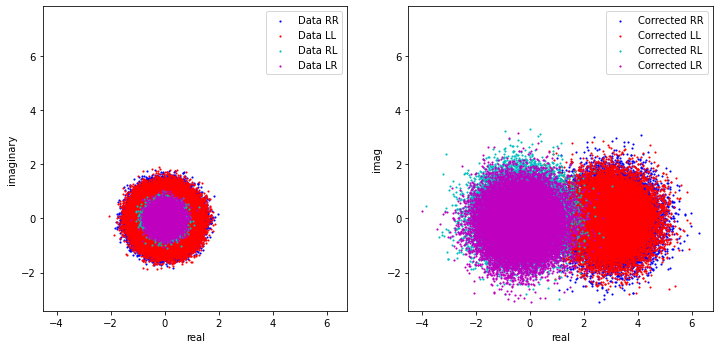

In [ ]:
import xarray as xr
import matplotlib.pylab as plt
import numpy as np
from cngi.vis import chan_average
from cngi.dio import read_vis
import dask

# Import the corrected data
sc_vis_mxds = read_vis("cor_selfcal_sim1_1scan.vis.zarr",chunks={'time':150})

# Select a single channel and a subset of time for plotting
xds = sc_vis_mxds.xds0.isel(chan=5,time=slice(0,20))
print(xds)

# References to the corrected correlations
RR_corr=np.ravel(xds.CORRECTED_DATA[:,:,0])
RL_corr=np.ravel(xds.CORRECTED_DATA[:,:,1])
LR_corr=np.ravel(xds.CORRECTED_DATA[:,:,2])
LL_corr=np.ravel(xds.CORRECTED_DATA[:,:,3])

# References to the raw data correlations
RR_data=np.ravel(xds.DATA[:,:,0])
RL_data=np.ravel(xds.DATA[:,:,1])
LR_data=np.ravel(xds.DATA[:,:,2])
LL_data=np.ravel(xds.DATA[:,:,3])


plt.figure(figsize=(12,8))
plt.subplot(122)
plt.scatter(RR_corr.real,RR_corr.imag,5,label='Corrected RR',c='b',marker='.')
plt.scatter(LL_corr.real,LL_corr.imag,5,label='Corrected LL',c='r',marker='.')
plt.scatter(RL_corr.real,RL_corr.imag,5,label='Corrected RL',c='c',marker='.')
plt.scatter(LR_corr.real,LR_corr.imag,5,label='Corrected LR',c='m',marker='.')
plt.xlabel('real')
plt.ylabel('imag')
plt.legend()
ax=list(plt.axis('square'))

plt.subplot(121)
plt.scatter(RR_data.real,RR_data.imag,5,label='Data RR',c='b',marker='.')
plt.scatter(LL_data.real,LL_data.imag,5,label='Data LL',c='r',marker='.')
plt.scatter(RL_data.real,RL_data.imag,5,label='Data RL',c='c',marker='.')
plt.scatter(LR_data.real,LR_data.imag,5,label='Data LR',c='m',marker='.')
plt.xlabel('real')
plt.ylabel('imaginary')
plt.legend()
plt.axis('square')
plt.axis(ax)

plt.show()


## Plot results II

In this section, we use CNGI functions to form a dataset averaged over time and frequency, and this better reveals the quality of the fully-calibrated result (as well as the nature of the systematic gain errors in the un-calibrated data).  In the plot, the uncalibrated data are distributed in phase and amplitude.  After calibration, the visibilities tightly cluster around the expected values: Stokes I at \~3 Jy (zero phase), Stokes V \~zero, and the cross-hands (conjugates of each other) revealing Q\~-0.36 and U\~0.15.

I= <xarray.DataArray 'CORRECTED_DATA' ()>
array(3.00001346)
Q= <xarray.DataArray 'CORRECTED_DATA' ()>
array(-0.35983528)
U= <xarray.DataArray 'CORRECTED_DATA' ()>
array(0.14953174)
V= <xarray.DataArray 'CORRECTED_DATA' ()>
array(-0.00058128)


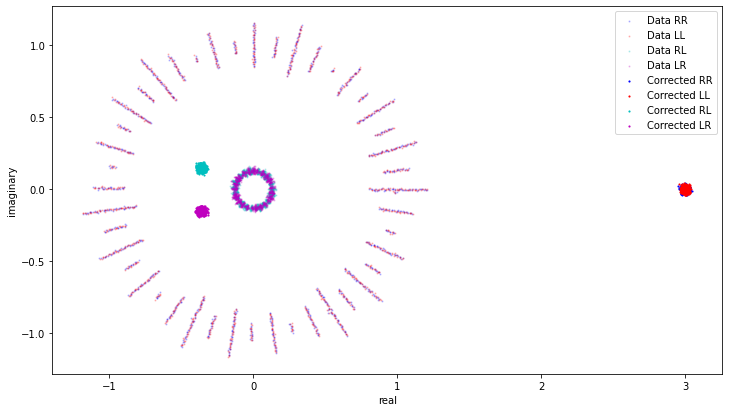

In [ ]:
import xarray as xr
import matplotlib.pylab as plt
import numpy as np
from cngi.vis import chan_average, time_average
from cngi.dio import read_vis
import dask

# Import the calibrated data
sc_vis_mxds = read_vis("cor_selfcal_sim1_1scan.vis.zarr",chunks={'time':150})

# Average in time and frequency via cngi function
mxds = time_average(chan_average(sc_vis_mxds,'xds0',width=11),'xds0',bin=300)
#print(mxds.xds0)
xds = mxds.xds0

# Average over baseline and report the calibrated Stokes parameters
CORR=np.mean(xds.CORRECTED_DATA,(0,1,2)).compute()
I=np.real(CORR[0]+CORR[3])/2.0
Q=np.real(CORR[1]+CORR[2])/2.0
U=np.imag(CORR[1]-CORR[2])/2.0
V=np.real(CORR[0]-CORR[3])/2.0
print('I=',I)
print('Q=',Q)
print('U=',U)
print('V=',V)

# References to the corrected correlations
RR_corr=np.ravel(xds.CORRECTED_DATA[:,:,:,0])
RL_corr=np.ravel(xds.CORRECTED_DATA[:,:,:,1])
LR_corr=np.ravel(xds.CORRECTED_DATA[:,:,:,2])
LL_corr=np.ravel(xds.CORRECTED_DATA[:,:,:,3])

# References to the raw data correlations
RR_data=np.ravel(xds.DATA[:,:,:,0])
RL_data=np.ravel(xds.DATA[:,:,:,1])
LR_data=np.ravel(xds.DATA[:,:,:,2])
LL_data=np.ravel(xds.DATA[:,:,:,3])

# Assemble the plot
plt.figure(figsize=(12,12))

# . . plot the uncorrected data
plt.scatter(RR_data.real,RR_data.imag,5,label='Data RR',c='b',marker='.',alpha=0.2)
plt.scatter(LL_data.real,LL_data.imag,5,label='Data LL',c='r',marker='.',alpha=0.2)
plt.scatter(RL_data.real,RL_data.imag,5,label='Data RL',c='c',marker='.',alpha=0.2)
plt.scatter(LR_data.real,LR_data.imag,5,label='Data LR',c='m',marker='.',alpha=0.2)

# . . plot the corrected data
plt.scatter(RR_corr.real,RR_corr.imag,5,label='Corrected RR',c='b',marker='.')
plt.scatter(LL_corr.real,LL_corr.imag,5,label='Corrected LL',c='r',marker='.')
plt.scatter(RL_corr.real,RL_corr.imag,5,label='Corrected RL',c='c',marker='.')
plt.scatter(LR_corr.real,LR_corr.imag,5,label='Corrected LR',c='m',marker='.')

# labels, etc.
plt.xlabel('real')
plt.ylabel('imaginary')
plt.legend()
plt.axis('scaled')
plt.show()
